# Generate figures and dataframes for Prescient simulator output

In [55]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

# List of RGB tuples for SNL/QuESt color palette
PALETTE_HEX = [(0, 83, 118), (132, 189, 0),
    (0, 173, 208), (255, 163, 0), (255, 88, 93), (174, 37, 115)]
PALETTE = []

for color_hex in PALETTE_HEX:
    # Convert to [0, 1] scale for rgb values.
    PALETTE.append(tuple([rgb_val/255 for rgb_val in color_hex]))

# Seaborn/matplotlib plot settings
sns.set()
sns.set_context('paper', font_scale=2.15)
sns.set_palette(PALETTE)

plt.rcParams["figure.figsize"] = (12,6)
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 18
        }
mpl.rc('font', **font)

## Set the simulator output directory

In [56]:
# case_prefix = '11_12_18_output_dispatchable'
# case_prefix = '11_26_18_sj_low_renewables_15res'
# case_prefix = '11_21_18_sj_inc_renewables_15res'
#case_prefix = '11_29_18_15res'
# case_prefix = '12_12_18_baseline'
# case_prefix = '12_12_18_scen_2'
case_prefix = '12_12_18_scen_3'

RESULTS_DIR = os.path.join('results', case_prefix)

# Set the directory to save figures
FIGS_DIR = os.path.join('..', '..', 'report', 'figs')

### Data for energy storage pricing

In [30]:
# Assume Li-ion: Energy (LiE)
li_ion_lifetime = 10  # 10 year lifetime

def get_energy_storage_costs(case_prefix):
    if case_prefix == '12_12_18_baseline':
        # Baseline
        li_ion_ppkwh = 451.8  # Li: 2-Hr
        li_ion_kwh = 200*1000  # 200 MWh
        li_ion_cost = 1.02*li_ion_kwh*li_ion_ppkwh  # 2% O&M
    else:
        # Developed
        li_ion_ppkwh = 410.5  # Li: 5-Hr
        li_ion_kwh = 500*1000  # 500 MWh
        li_ion_cost = 2*1.02*li_ion_kwh*li_ion_ppkwh  # 2% O&M, 2 "units"

    li_ion_cost_py = li_ion_cost / li_ion_lifetime
    li_ion_cost_eval_period = li_ion_cost_py / 12 / 2  # half month
    
    print(li_ion_cost, li_ion_cost_eval_period)
    
    return li_ion_cost_eval_period

### Data for PV and wind "costs"

In [57]:
def get_renewable_costs(case_prefix):
    # cost data
#     pv_ppmwh = 0.163*1e3  # $0.163 $/kWh
#     pv_ppmwh = 0.0579*1e3
    pv_ppmwh = 40+8  # $40/MWh
    wind_ppmwh = 20+9  # $20/MWh
    
    
    df_renewable_detail = pd.read_csv(os.path.join(RESULTS_DIR, 'renewables_detail.csv'))
    df_renewable_detail['Total Generated'] = df_renewable_detail['Curtailment'] + df_renewable_detail['Output']
    
    df = df_renewable_detail[['Date', 'Generator', 'Hour', 'Total Generated']]
    pv_output_total = df[df['Generator'].str.startswith('PV')]['Total Generated'].sum()
    
    wind_output_total = df[df['Generator'].str.startswith('WT')]['Total Generated'].sum()
    
    return pv_output_total*pv_ppmwh, wind_output_total*wind_ppmwh

## Case analysis

### Sample PV and wind shapes

In [58]:
# SHAPES_DIR = os.path.join('results', 'nm_system_scens', 'pyspdir_twostage', '2026-06-01')
# scenarios_file = os.path.join(SHAPES_DIR, 'scenarios.csv')

# scenarios_df = pd.read_csv(scenarios_file)

# _, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# scenarios_df['PV-Fixed_NM_SO_2026[05]: actuals'].plot(ax=ax[0], style='o-')
# ax[0].set_xlabel('hour')
# ax[0].set_title('South NM Fixed PV Shape')
# ax[0].set_yticklabels([])

# # plt.gca().axes.get_yaxis().set_visible(False)

# scenarios_df['WT-E_NM_EA_2026[05]: actuals'].plot(ax=ax[1], style='o-')
# ax[1].set_xlabel('hour')
# ax[1].set_title('East NM Wind Shape')
# ax[1].set_yticklabels([])

# # plt.gca().axes.get_yaxis().set_visible(False)

# plt.savefig(os.path.join(FIGS_DIR, 'sample_pv_wind_shapes.png'), bbox_inches='tight')

In [59]:
def convert_df_datetime(df, set_index=False):
    """Converts date and hour columns of Prescient output sheets to single datetime column."""
    
    try:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')
        df['dt'] = df['Date'] + df['Hour']
        df.drop(columns=['Date', 'Hour'], inplace=True)
    except KeyError:
        df['Date '] = pd.to_datetime(df['Date '])
        df[' Hour '] = pd.to_timedelta(df[' Hour '], unit='h')
        df['dt'] = df['Date '] + df[' Hour ']
        df.drop(columns=['Date ', ' Hour '], inplace=True)
    
    if set_index:
        df.set_index('dt', inplace=True)
    
    return df
    

In [61]:
def generate_bar_chart(chart_data, bar_width=0.4, labels=[], orientation='vertical'):
    """Creates a bar chart for revenue using chart_data."""
    _, ax = plt.subplots(figsize=(12, 4))

    indices = np.arange(len(chart_data))

    # Plot.
    with sns.axes_style('whitegrid'):
        if orientation == 'horizontal':
            ax.barh(indices, chart_data, height=bar_width, color=PALETTE)
            plt.yticks(indices, labels, rotation=0)
            ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])  # Comma separator for y-axis tick labels.
        else:
            ax.bar(indices, chart_data, width=bar_width, color=PALETTE)
            plt.xticks(indices, labels, rotation=0)
            ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])  # Comma separator for y-axis tick labels.
            
        # sb.despine(offset=10, trim=True)

    return ax

## Overall simulation output

In [35]:
# Categories for costs
cat_keys = ['Total costs', 'Energy Storage Cost', 'Wind Cost', 'Solar Cost',]
cat_names = ['Thermal', 'Energy Storage', 'Wind', 'Solar',]

In [62]:
def generate_costs_donut_chart(chart_record):
    """Creates a donut chart for costs."""
    fig, ax = plt.subplots(figsize=(12, 6))

    ## Determine which colors to use.
    colors_list = PALETTE
    
    donut_data = [chart_record[cat] for cat in cat_keys]

    # Plot.
#     donut_data = sorted(donut_data, key=lambda x: x[1], reverse=True)
#     data = [source[-1] for source in donut_data]

    def _pctfunc(pct, data):
        """Function to pass to pie() to create wedge percentage labels."""
        THRESHOLD = 0

        if pct < THRESHOLD:
            return_str = ''
        else:
            return_str = "{:.1f}%\n(${:,d} K)".format(pct, int(pct/100*np.sum(data)*1e-3))

        return return_str

    wedges, _, _ = ax.pie(donut_data, radius=1, autopct=lambda pct: _pctfunc(pct, donut_data), pctdistance=1.3, center=(-1, 0), startangle=90, counterclock=False, colors=colors_list, shadow=False, wedgeprops=dict(width=0.33, linewidth=2, edgecolor='w'), textprops={'fontsize': 14})

    ax.set(aspect="equal", 
#            title='Overall Costs'
          )
    ax.legend(wedges, cat_names, loc="center left", bbox_to_anchor=(1.1, 0, 0.5, 1))
    plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_costs_donut.png'), bbox_inches='tight')

    return fig, ax

In [63]:
def generate_costs_stackedbar_chart(chart_data, bar_width=0.6, labels=[]):
    """Creates a stacked bar chart for costs using chart_data."""
    fig, ax = plt.subplots(figsize=(16, 6))

    # Determine which colors to use.
    colors_list = PALETTE

    indices = np.arange(len(chart_data))
    bottom = np.zeros(len(indices))

    ## Compute the activity counts for each activity category.
    for ix, cat in enumerate(cat_keys, start=0):
        component_color = colors_list[ix]
        
        vals = [x[cat]*1e-3 for x in chart_data]
        
        # Plot set of bar stack component.
        ax.bar(indices, vals, bar_width, bottom=bottom, color=component_color, label=cat_names[ix])

        # Update "bottom" position for each stack. 
        bottom += vals

    plt.xticks(indices, labels, rotation=0)
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
    
    sns.despine(offset=10, trim=True)

    # Put legend outside on the right.
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title('Overall Costs')
    ax.set_ylabel('in thousands of $')
    # ax.yaxis.grid(True)

    return fig, ax

In [38]:
def overall_simulation_output(results_dir):
    df_overall = pd.read_csv(os.path.join(results_dir, 'Overall_simulation_output.csv'))
    
    return df_overall

In [39]:
df_overall = overall_simulation_output(RESULTS_DIR)
df_overall

,Total demand,Total fixed costs,Total generation costs,Total costs,Total load shedding,Total over generation,Total reserve shortfall,Total renewables curtialment,Total on/offs,Total sum on/off ramps,Total sum nominal ramps,Maximum observed demand,Overall renewables penetration rate,Cumulative average price
0,1.132800e+06,2.969321e+07,125075.773549,2.981828e+07,0.0,46849.09927,13232.077479,38561.765213,842.0,30781.633091,23762.336179,4124.96647,73.93092,23.773981


In [40]:
df_overall['Energy Storage Cost'] = get_energy_storage_costs(case_prefix)
df_overall['Solar Cost'], df_overall['Wind Cost'] = get_renewable_costs(case_prefix)
df_overall_records = df_overall.to_dict(orient='records')

labels = ['Scenario 2']

# fig, ax = generate_costs_stackedbar_chart(df_overall_records, labels=labels)

418710000.0 1744625.0


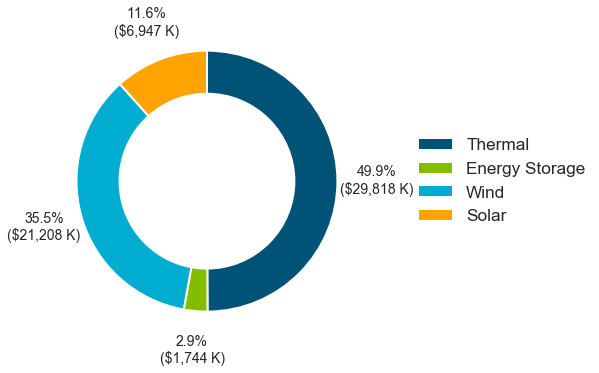

In [41]:
fig, ax = generate_costs_donut_chart(df_overall_records[0])

## Bus Detail

In [42]:
def bus_detail(results_dir):
    df_bus_detail = pd.read_csv(os.path.join(results_dir, 'bus_detail.csv'))
    
    return df_bus_detail

In [43]:
df_bus_detail = bus_detail(RESULTS_DIR)
df_bus_detail.describe()

,Hour,LMP,Overgeneration,Shortfall
count,360.000000,360.000000,360.000000,360.0
mean,12.500000,-2704.964376,130.136387,0.0
std,6.931821,4655.569596,324.029155,0.0
min,1.000000,-11000.000000,0.000000,0.0
25%,6.750000,-1000.000000,0.000000,0.0
50%,12.500000,0.828657,0.000000,0.0
75%,18.250000,1.155507,0.000000,0.0
max,24.000000,2.251123,1874.111590,0.0


## Daily summary

In [44]:
def daily_summary(results_dir, plots=True):
    df_daily_summary = pd.read_csv(os.path.join(results_dir, 'Daily_summary.csv'))
    
    if plots:  
        # Costs
#         fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 10))

        
        indices = range(len(df_daily_summary))
        
#         axes[0].bar(indices, df_daily_summary[' TotalCosts ']*1e-3, color=PALETTE)
#         axes[0].set_ylabel('Total Costs [in $K]')

        axes[0].bar(indices, df_daily_summary['Fixed costs']*1e-3, color=PALETTE)
        axes[0].set_ylabel('Fixed Costs [in $K]')

        axes[1].bar(indices, df_daily_summary['Generation costs']*1e-3, color=PALETTE)
        axes[1].set_ylabel('Variable Costs [in $K]')
        plt.xticks(indices, df_daily_summary['Date'], rotation=90)
        
        for ax in axes:
            ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_daily_costs.png'), bbox_inches='tight')
        
        # Renewables
        fig, ax = plt.subplots(figsize=(12,4))
        bottom = np.zeros(len(indices))

        renewable_cats = ['Renewables used', 'Renewables curtailment']
        
        for ix, cat in enumerate(renewable_cats, start=0):
            component_color = PALETTE[ix]
            
            # Plot set of bar stack component.
            ax.bar(indices, df_daily_summary[cat], bottom=bottom, color=component_color, label=cat[11:])

            # Update "bottom" position for each stack. 
            bottom += df_daily_summary[cat]

        plt.xticks(indices, df_daily_summary['Date'], rotation=90)

        # Put legend outside on the right.
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*1.0, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        ax.set_title('Renewables Available')
        ax.set_ylabel('MWh')
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_daily_renewables.png'), bbox_inches='tight')
    
    return df_daily_summary

,Demand,Renewables available,Renewables used,Renewables penetration rate,Average price,Fixed costs,Generation costs,Load shedding,Over generation,Reserve shortfall,Renewables curtailment,On/off,Sum on/off ramps,Sum nominal ramps,Number on/offs
count,15.000000,15.000000,15.000000,15.000000,15.000000,1.500000e+01,15.000000,15.0,15.000000,15.000000,15.000000,0.0,15.000000,15.000000,15.000000
mean,75519.977065,58403.398333,55832.613986,73.870176,26.319765,1.979547e+06,8338.384903,0.0,3123.273285,882.138499,2570.784348,NaN,2052.108873,1584.155745,56.133333
std,3294.301368,12037.773170,11145.031177,14.008561,9.338171,7.186529e+05,3940.311257,0.0,3570.192213,438.205280,1290.337040,NaN,678.887650,400.917627,13.721030
min,69608.343660,38484.094000,37391.440700,48.058647,12.439949,9.434614e+05,2572.953973,0.0,0.000000,296.903722,0.000000,NaN,875.563591,897.717106,35.000000
25%,73364.534320,51365.227000,48963.468441,66.627595,19.052309,1.394306e+06,4639.449963,0.0,860.257760,554.909317,1808.409805,NaN,1534.670118,1324.854856,47.500000
50%,74988.884430,57161.424000,54980.172960,73.444824,26.792075,2.012766e+06,8557.579460,0.0,2481.550960,827.766505,2181.251040,NaN,1915.761593,1592.618369,54.000000
75%,78358.278205,68211.376500,65170.376420,85.379241,34.074098,2.391382e+06,10715.588251,0.0,4374.717420,1099.157462,3536.896623,NaN,2573.260135,1834.931601,62.500000
max,80863.783960,76868.132000,72172.467500,92.929751,42.948405,3.423444e+06,15750.482221,0.0,14082.935720,1722.751520,4695.664500,NaN,3121.010662,2249.474453,92.000000


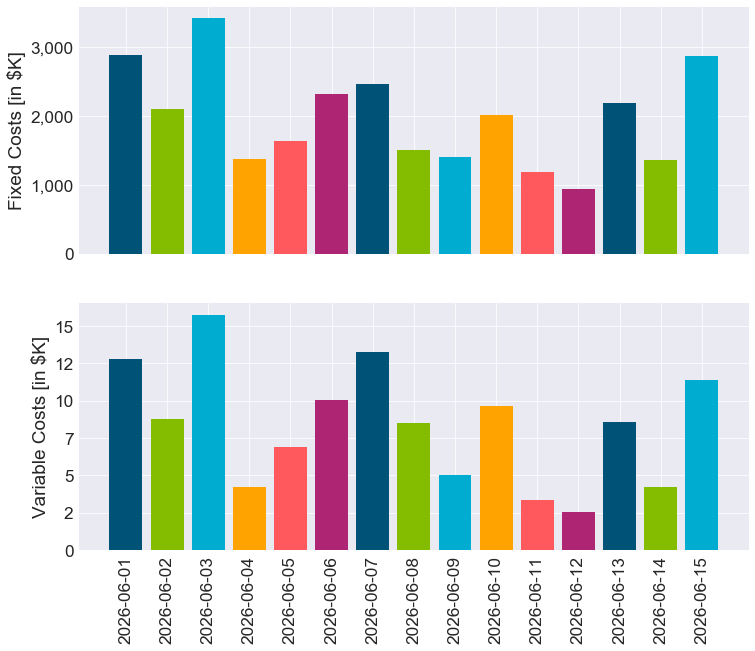

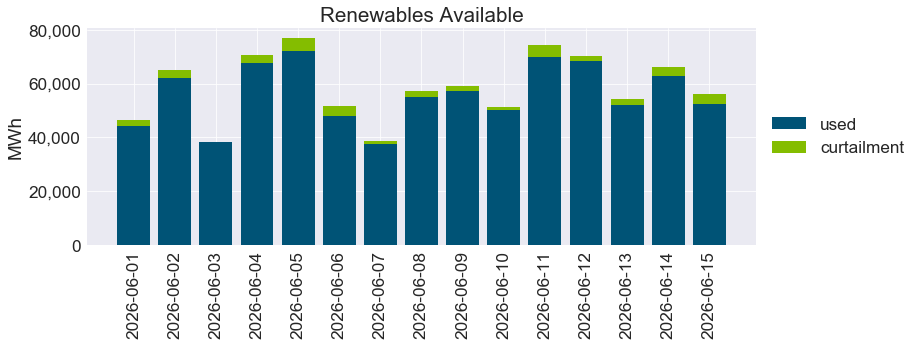

In [45]:
df_daily_summary = daily_summary(RESULTS_DIR)
df_daily_summary.describe()

## Hourly gen summary

In [46]:
def hourly_gen_summary(results_dir, plots=True):
    df_hourly_gen_summary = pd.read_csv(os.path.join(RESULTS_DIR, 'Hourly_gen_summary.csv'))
    df_hourly_gen_summary = convert_df_datetime(df_hourly_gen_summary, set_index=True)
    
    if plots:
#         fig, ax = plt.subplots(figsize=(16,4))
#         sns.distplot(df_hourly_gen_summary['Load shedding'], kde=False, ax=ax)
        
#         ax.set_title('Load Shedding')
#         ax.set_ylabel('Frequency')
#         ax.set_xlabel('MW')
        
#         plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_hourly_load_shedding.png'), bbox_inches='tight')
        
        fig, ax = plt.subplots()
        sns.distplot(df_hourly_gen_summary['Reserve shortfall'], kde=False, ax=ax)
        
        ax.set_title('Reserve Shortfall')
#         ax[1].set_ylabel('Frequency')
        ax.set_xlabel('MW')
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_hist_reserveshortfall.png'), bbox_inches='tight')
    
    return df_hourly_gen_summary

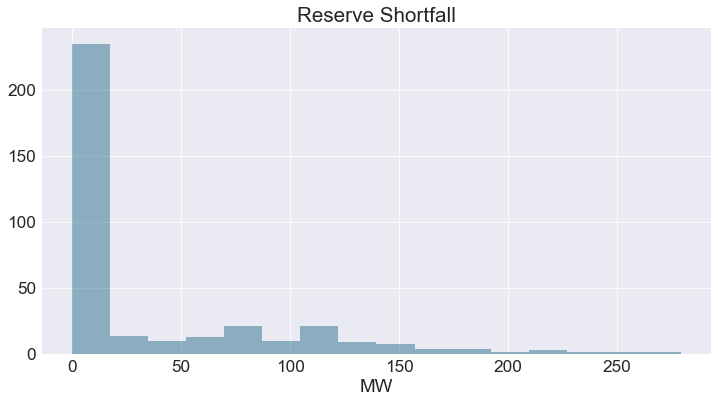

In [47]:
df_hourly_gen_summary = hourly_gen_summary(RESULTS_DIR)

## Hourly summary

In [48]:
def hourly_summary(results_dir, plot=True):
    df_hourly_summary = pd.read_csv(os.path.join(results_dir, 'hourly_summary.csv'))
    df_hourly_summary = convert_df_datetime(df_hourly_summary, set_index=True)
    
    if plot:
        # Demand vs. Renewables Used
        fig, ax = plt.subplots()
        
        # sns.lineplot(y=[' Demand ', ' RenewablesUsed '], data=df_hourly_summary, palette=PALETTE)
        df_hourly_summary[' Demand '].plot(ax=ax, label='Demand')
        df_hourly_summary[' RenewablesUsed '].plot(ax=ax, label='Renewables Used')
        # ax.plot(df_hourly_summary[' Demand '], label='Demand')
        # ax.plot(df_hourly_summary[' RenewablesUsed '], label='Renewables Used')
        ax.legend(loc='best')
        ax.set_xlabel('Time')
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])  # Comma separator for y-axis tick labels.
        ax.set_ylabel('MW')
        ax.set_title('Demand vs. Renewables Used')
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_hourly_demand_v_renewables.png'), bbox_inches='tight')
        
        # Renewables Curtailed
        fig, ax = plt.subplots()

        sns.distplot(df_hourly_summary[' RenewablesCurtailed '], kde=False, ax=ax, bins=10)
        ax.set_xlabel('MW')
        # ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])  # Comma separator for y-axis tick labels.
        ax.set_ylabel('Frequency')
        ax.set_title('Renewables Curtailment')
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_hourly_renewables_curtailed.png'), bbox_inches='tight')
        
        # Cumulative Total Costs
        fig, ax = plt.subplots()
        
        (df_hourly_summary[' TotalCosts '].cumsum()*1e-3).plot(ax=ax)
        ax.set_xlabel('Time')
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
        ax.set_ylabel('in thousands of $')
        ax.set_title('Cumulative Total Costs')
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_hourly_cumulative_costs.png'), bbox_inches='tight')
        
        # Price regression
        fig, ax = plt.subplots()
        
        sns.regplot(' RenewablesUsed ', ' Price', data=df_hourly_summary, lowess=True,)
        # df_hourly_summary[' Price'].plot()
        ax.set_xlabel('Renewables Used [MWh]')
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
        ax.set_ylabel('Price [$/MWh]')
        ax.set_title('Price vs. Renewables Used')
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_hourly_price_v_renewables.png'), bbox_inches='tight')
    
    return df_hourly_summary

,TotalCosts,FixedCosts,VariableCosts,LoadShedding,OverGeneration,ReserveShortfall,RenewablesUsed,RenewablesCurtailed,Demand,Price
count,360.000000,360.000000,360.000000,360.0,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,82828.563447,82481.130743,347.432704,0.0,130.136387,36.755771,2326.358916,107.116014,3146.665711,24.139946
std,82282.119913,81910.685044,395.264708,0.0,324.029155,59.794254,969.398337,164.515384,536.454854,22.058049
min,4931.393561,4931.393561,0.000000,0.0,0.000000,0.000000,304.195000,0.000000,2253.772580,1.386751
25%,10159.525901,10159.525901,0.000000,0.0,0.000000,0.000000,1663.707750,0.000000,2626.965665,3.830879
50%,49542.246885,49389.951126,155.309964,0.0,0.000000,0.000000,2391.106000,0.000000,3195.956135,15.910941
75%,146271.958712,145575.651196,650.252848,0.0,0.000000,65.978150,3006.786000,286.051500,3565.973178,40.501397
max,329143.028507,327785.506137,1601.106171,0.0,1874.111590,279.231523,4846.491900,538.499100,4257.857970,78.757672


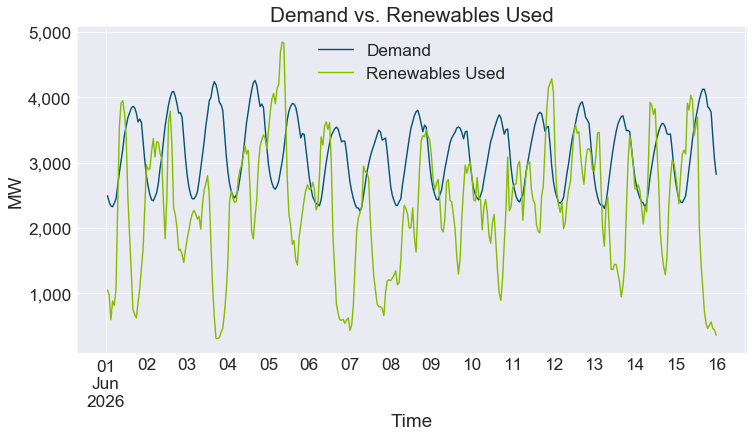

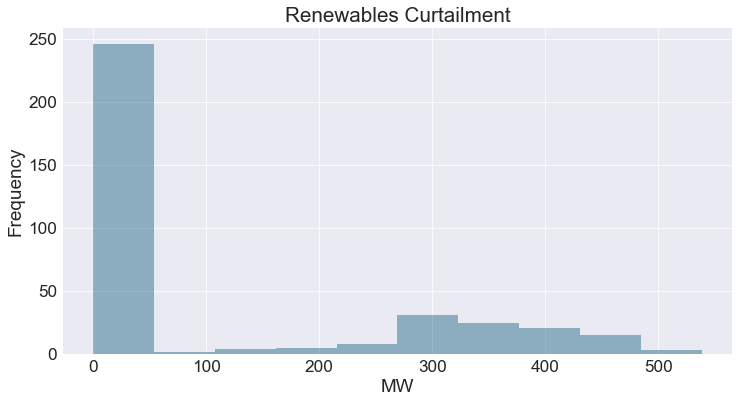

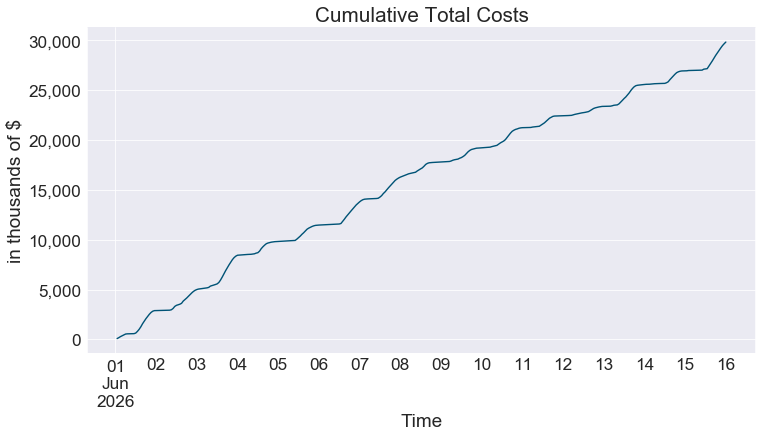

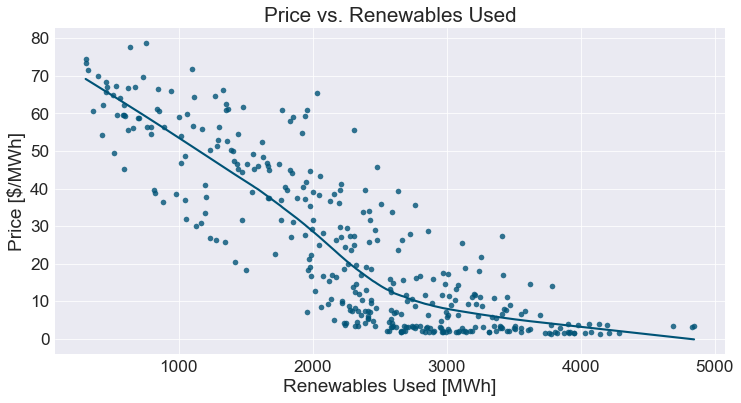

In [49]:
df_hourly_summary = hourly_summary(RESULTS_DIR)
df_hourly_summary.describe()

## Thermal detail

In [50]:
def thermal_detail(results_dir, plot=True):
    df_thermal = pd.read_csv(os.path.join(results_dir, 'thermal_detail.csv'))
    df_thermal = convert_df_datetime(df_thermal, set_index=True)
    
    if plot:
        # Dispatch
        fig, ax = plt.subplots(figsize=(16, 4))
        
        df_thermal_dispatch = df_thermal.loc[:, ['Dispatch', 'Generator']]
        df_thermal_dispatch = df_thermal_dispatch.pivot(columns="Generator", values="Dispatch")
        dispatch_sum = df_thermal_dispatch.sum(axis=0)

        ax.bar(range(len(dispatch_sum)), dispatch_sum, color=PALETTE)
        ax.set_ylabel('MWh')
        ax.set_title('Total Dispatch')
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
        plt.xticks(range(len(dispatch_sum)), dispatch_sum.index, rotation=90);
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_thermal_dispatch.png'), bbox_inches='tight')
        
        # Unit State
        df_thermal_unit_state = df_thermal.loc[:, ['Unit State', 'Generator']]
        df_thermal_unit_state = df_thermal_unit_state.pivot(columns="Generator", values="Unit State")
        gen_uptime = df_thermal_unit_state.mean(axis=0)

        fig, ax = plt.subplots(figsize=(16, 4))
        ax.bar(range(len(gen_uptime)), gen_uptime, color=PALETTE)
        ax.set_ylabel('Uptime')
        ax.set_title('Generator Uptime')
        plt.xticks(range(len(gen_uptime)), gen_uptime.index, rotation=90);
        
        plt.savefig(os.path.join(FIGS_DIR, case_prefix + '_thermal_uptime.png'), bbox_inches='tight')
    
    return df_thermal

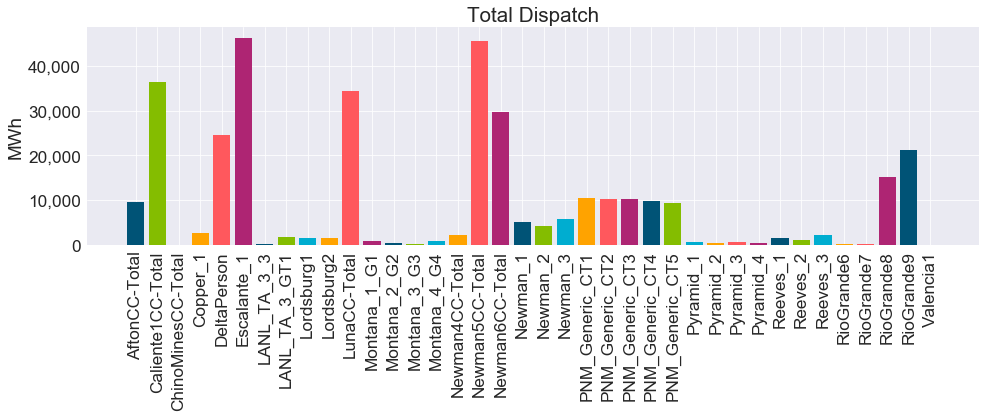

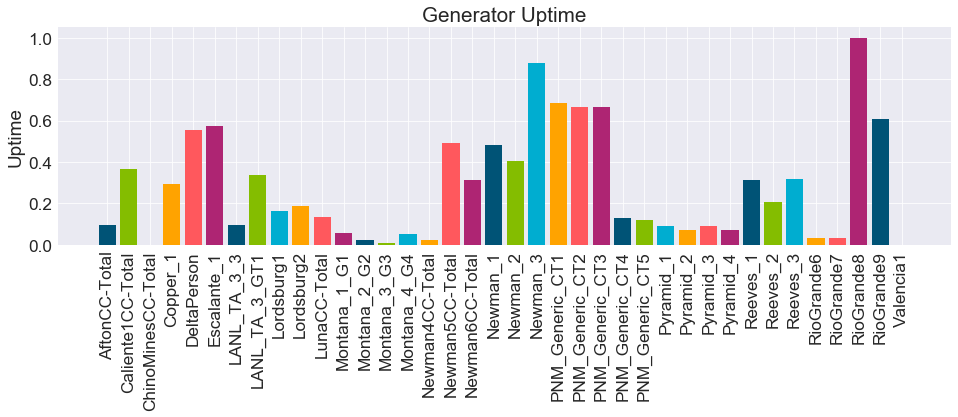

In [51]:
df_thermal = thermal_detail(RESULTS_DIR)

## Scenario comparison

92167200.0 384030.0
418710000.0 1744625.0
418710000.0 1744625.0
[{'Total demand': 1132799.65598, 'Total fixed costs': 28235415.15953289, 'Total generation costs': 201101.4416369907, 'Total costs': 28436516.60116988, 'Total load shedding': 0.0, 'Total over generation': 0.0, 'Total reserve shortfall': 397.16146411294801, 'Total renewables curtialment': 0.0, 'Total on/offs': 472.0, 'Total sum on/off ramps': 11926.676341500501, 'Total sum nominal ramps': 31412.675458471444, 'Maximum observed demand': 4124.9664700000003, 'Overall renewables penetration rate': 25.587847018653889, 'Cumulative average price': 23.069591666408282, 'Energy Storage Cost': 384030.0, 'Solar Cost': 3710017.1039999994, 'Wind Cost': 6164443.5800000001}, {'Total demand': 1132799.65598, 'Total fixed costs': 22278064.090535626, 'Total generation costs': 78557.789820759252, 'Total costs': 22356621.880356386, 'Total load shedding': 0.0, 'Total over generation': 86764.440010733611, 'Total reserve shortfall': 8194.88165383426

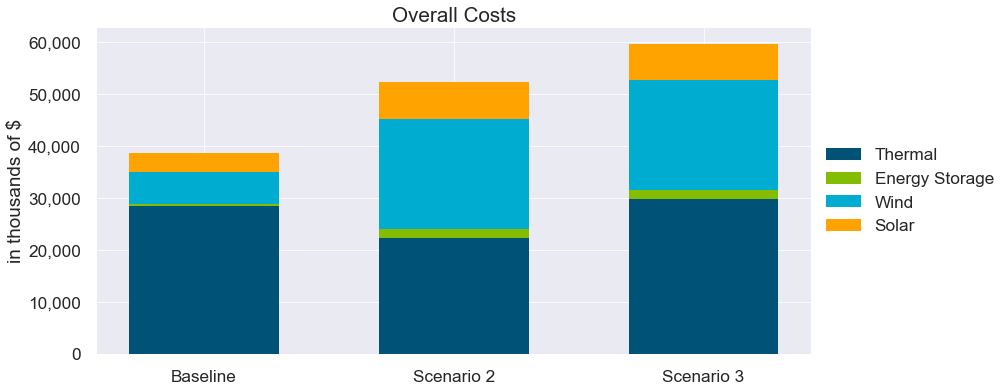

In [52]:
scenario_prefixes = [
    '12_12_18_baseline', 
     '12_12_18_scen_2', 
     '12_12_18_scen_3',
]

labels = [
    'Baseline', 
    'Scenario 2', 
    'Scenario 3',
]

records = []

for prefix in scenario_prefixes:
    RESULTS_DIR = os.path.join('results', prefix)
    
    df_overall = overall_simulation_output(RESULTS_DIR)
    
    df_overall['Energy Storage Cost'] = get_energy_storage_costs(prefix)
    df_overall['Solar Cost'], df_overall['Wind Cost'] = get_renewable_costs(case_prefix)
    records.append(df_overall.to_dict(orient='records')[0])

print(records)

fig, ax = generate_costs_stackedbar_chart(records, labels=labels)
plt.savefig(os.path.join(FIGS_DIR, 'comparison_total_costs.png'), bbox_inches='tight')
    
    


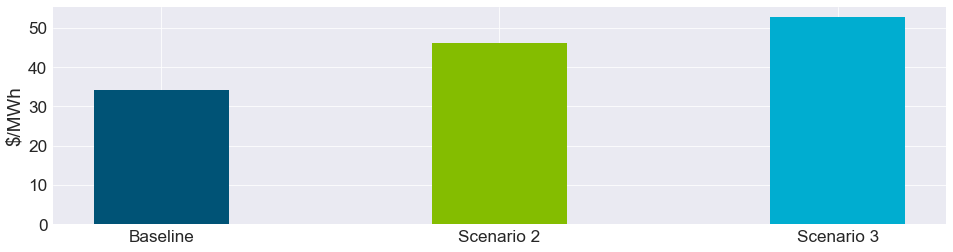

In [53]:
def generate_avg_price(records):
    fig, ax = plt.subplots(figsize=(16, 4))

    for record in records:
        record['Augmented Total Costs'] = record['Total costs'] + record['Energy Storage Cost'] + record['Solar Cost'] + record['Wind Cost']
        record['Price per MWh'] = record['Augmented Total Costs']/record['Total demand']

    ax.bar(range(len(records)), [x['Price per MWh'] for x in records], color=PALETTE, width=0.4)
    ax.set_ylabel('$/MWh')
#     ax.set_title('Total Dispatch')
#     ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
    plt.xticks(range(len(records)), labels);

    plt.savefig(os.path.join(FIGS_DIR, 'comparison_ppmwh.png'), bbox_inches='tight')
    
    return fig, ax, records

fig, ax, records = generate_avg_price(records)

In [54]:
pd.DataFrame.from_records(records)

,Augmented Total Costs,Cumulative average price,Energy Storage Cost,Maximum observed demand,Overall renewables penetration rate,Price per MWh,Solar Cost,Total costs,Total demand,Total fixed costs,Total generation costs,Total load shedding,Total on/offs,Total over generation,Total renewables curtialment,Total reserve shortfall,Total sum nominal ramps,Total sum on/off ramps,Wind Cost
0,3.869501e+07,23.069592,384030.0,4124.96647,25.587847,34.158739,3710017.104,2.843652e+07,1.132800e+06,2.823542e+07,201101.441637,0.0,472.0,0.000000,0.000000,397.161464,31412.675458,11926.676342,6.164444e+06
1,5.225663e+07,18.149764,1744625.0,4124.96647,73.156458,46.130517,6947138.928,2.235662e+07,1.132800e+06,2.227806e+07,78557.789821,0.0,598.0,86764.440011,47334.867688,8194.881654,32824.429804,20028.709849,2.120825e+07
2,5.971830e+07,23.773981,1744625.0,4124.96647,73.930920,52.717438,6947138.928,2.981828e+07,1.132800e+06,2.969321e+07,125075.773549,0.0,842.0,46849.099270,38561.765213,13232.077479,23762.336179,30781.633091,2.120825e+07
